In [27]:
## data transform:
import pandas as pd
import networkx as nx 
import numpy as np

## support: 
from pathlib import Path
from tqdm import tqdm

## model: 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 

## viz: 
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()

In [9]:
def get_edge_list(data_train): 
    """Подготовка списка ребер для train-датасета"""
    for col in ['t', 'x1', 'x2', 'x3']:
        if col in data_train: 
            data_train.drop(col, inplace=True, axis=1)
    
    data_train_groupped = data_train.groupby('ego_id').agg({'u': lambda x: [el for el in x],
                                                            'v': lambda x: [el for el in x]})
    return data_train_groupped


def graph_embedding(graph: nx.Graph): 
    """Подготовка векторного отображения соотв. его графа"""
    graph_stats = dict() 
    density = nx.density(graph)
    degrees = list(map(lambda x: x[1], list(graph.degree))) 
    graph_stats['density'] = nx.density(graph)
    graph_stats['avg_deg'] = sum(degrees)/len(degrees)
    graph_stats['max_deg'] = max(degrees)
    graph_stats['med_deg'] = np.median(degrees)
    graph_stats['min_deg'] = min(degrees)
    graph_stats['num_nodes'] = graph.number_of_nodes() 
    graph_stats['num_edges'] = graph.number_of_edges()
    graph_stats['ratio_edges2nodes'] = graph_stats['num_edges']/graph_stats['num_nodes']
    graph_stats['q75_deg'] = np.quantile(degrees, .75)
    graph_stats['q25_deg'] = np.quantile(degrees, .25)

    return graph_stats

def get_ego2nx(data_train_groupped):
    """Создание словаря key=ego_id;value=nx.Graph"""
    ego2nx = dict() 

    for ego_id, row in tqdm(data_train_groupped.iterrows()): 
        ego2nx[ego_id] = nx.Graph() 
        ego2nx[ego_id].add_edges_from(list(zip(row['u'], row['v'])))
    return ego2nx

def get_graph_embeddings_without_nx(data_train_groupped): 
    """Получение датафрейма, содержащего данные о векторизациии эго-графов"""
    data = list() 

    for ego_id, row in tqdm(data_train_groupped.iterrows(), desc='graph emb. created'): 
        graph = nx.Graph() 
        graph.add_edges_from(list(zip(row['u'], row['v'])))
        stats = graph_embedding(graph)
        data.append({"ego_id": ego_id, **stats}) 
    return pd.DataFrame.from_records(data)    
    
def get_graph_embeddings(ego2nx): 
    """"""
    data = list() 
    for ego, graph in ego2nx.items(): 
        graph_stats = graph_embedding(graph)
        data.append({"ego_id": ego, **graph_stats}) 

    return pd.DataFrame.from_records(data)

graph emb. created: 61786it [05:23, 191.14it/s]


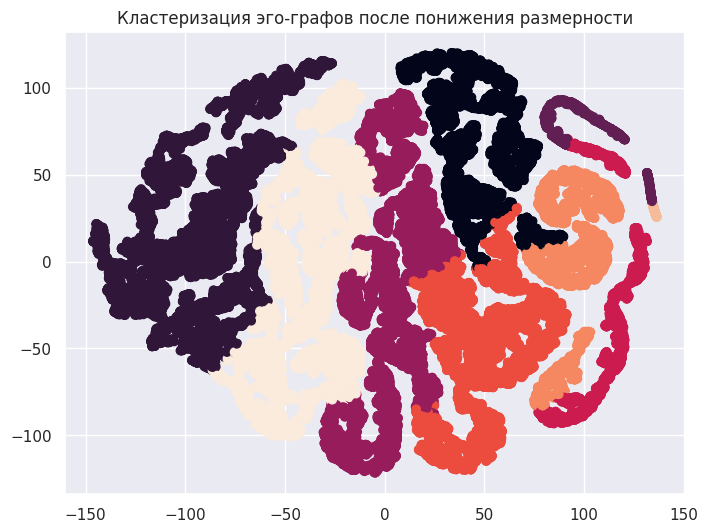

In [34]:
## Чтение исходных файлов train.csv, test.csv:
DATA_FOLDER = Path('../../data')
_, _, test_path, train_path = sorted(DATA_FOLDER.glob("*.csv"))
train_data = pd.read_csv(train_path)

## Группировка ребер по соотв. эго-графам: 
data_train_groupped = get_edge_list(train_data)
## Векторное отображение эго-графов:
graph_embeddings = get_graph_embeddings_without_nx(data_train_groupped)
## Понижение размерности векторных отображений для визуализации:
X_reduced_dim = TSNE(n_components=2).fit_transform(graph_embeddings.drop('ego_id', axis=1)) 

## Обучение модели KMeans++
kmean = KMeans(n_clusters=9, n_init=40)
pred_clusters = kmean.fit_predict(graph_embeddings.drop('ego_id', axis=1))

## Визуализация результатов: 
plt.figure(figsize=(8,6))
plt.title('Кластеризация эго-графов после понижения размерности')
plt.scatter(X_reduced_dim[:,0], X_reduced_dim[:,1], c=pred_clusters)

In [45]:
## Чтение тестовых данных [TEST]: 
test_data = pd.read_csv(test_path)

## Группировка ребер по соотв. эго-графам [TEST]: 
data_test_groupped = get_edge_list(test_data)
## Векторное отображение эго-графов [TEST]:
graph_embeddings_test = get_graph_embeddings_without_nx(data_test_groupped)

## Использование kmean на test-выборке:
pred_test_clusters = kmean.predict(graph_embeddings_test.drop('ego_id', axis=1))

graph emb. created: 20596it [01:36, 212.34it/s]


In [38]:
## Заполенение поля @cluster@ [TRAIN]
data_train_groupped['cluster'] = pred_clusters
data_train_groupped.drop(['u', 'v'], axis=1, inplace=True)

In [46]:
## Заполенение поля @cluster@ [TEST]
data_test_groupped['cluster'] = pred_test_clusters
data_test_groupped.drop(['u', 'v'], axis=1, inplace=True)

In [49]:
## Запись резульаттов кластеризации:
data_test_groupped.to_csv('data/clustering_result_test.csv')
data_train_groupped.to_csv('data/clustering_result_train.csv')